### Optimal Transport

#### Embeddings

In [2]:
from Process_Data.Datasets.KaldiDataset import ScriptTrainDataset
from Light.dataset import Sampler_Loaders, SubScriptDatasets

import os
from hyperpyyaml import load_hyperpyyaml
from Light.model import SpeakerLoss
from geomloss import SamplesLoss

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
torch.cuda.set_device(1)
device = 'cuda:1'

In [4]:
data_root = '/home/yangwenhao/project/SpeakerVerification-pytorch'

In [5]:
# train_config = 'data/vox2/model.2024.01.29.yaml'
train_config = 'data/vox1/model.2024.03.15.yaml'

In [6]:
with open(train_config, 'r') as f:
    config_args = load_hyperpyyaml(f)

In [8]:
if 'embedding_model' in config_args:
    model = config_args['embedding_model']

if 'classifier' in config_args:
    model.classifier = config_args['classifier']
# else:
#     if not isinstance(model.classifier, Classifier):
#         create_classifier(model, **config_args)

In [9]:
model.loss = SpeakerLoss(config_args)

In [10]:
model = model.cuda()

In [11]:
# resume = 'Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox2/wave_fb80_dist_aug53/1234/checkpoint_3.pth'
resume = 'Data/checkpoint/ECAPA_brain/Mean_batch96_SASP2_em192_official_2s/arcsoft_adam_cyclic/vox1/wave_fb80_inst_aug53/1234/checkpoint_3.pth'
checkpoint = torch.load(os.path.join(data_root, resume), map_location='cpu') #, map_location='cuda:1')

In [12]:
start_epoch = checkpoint['epoch']
checkpoint_state_dict = checkpoint['state_dict']
if isinstance(checkpoint_state_dict, tuple):
    checkpoint_state_dict = checkpoint_state_dict[0]

filtered = {k: v for k, v in checkpoint_state_dict.items(
) if 'num_batches_tracked' not in k}

# filtered = {k: v for k, v in checkpoint['state_dict'].items() if 'num_batches_tracked' not in k}
if list(filtered.keys())[0].startswith('module'):
    new_state_dict = OrderedDict()
    for k, v in filtered.items():
        # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
        new_state_dict[k[7:]] = v  # 新字典的key值对应的value为一一对应的值。

    model.load_state_dict(new_state_dict)
else:
    model_dict = model.state_dict()
    model_dict.update(filtered)
    model.load_state_dict(model_dict)

In [13]:
train_dir, valid_dir, train_extract_dir = SubScriptDatasets(config_args)

In [14]:
batch_size = config_args['batch_size'] 
num_classes = config_args['num_classes']
# model.eval()

batch_loader = torch.utils.data.DataLoader(
    train_dir, batch_size=batch_size, num_workers=config_args['nj'])
sample_num = len(train_dir)

In [15]:
embedding_dim = config_args['embedding_size']
embeddings = torch.zeros([len(train_dir), embedding_dim], requires_grad=False)

In [16]:
sample_num = len(train_dir)

In [17]:
pbar = tqdm(enumerate(batch_loader), ncols=50, total=len(batch_loader))
model.eval()

with torch.no_grad():
    for i, (data, label) in pbar:
        _, embedding = model(data.to(device))
        embeddings[i * batch_size:min((i+1) * batch_size, sample_num)] += embedding.cpu()
    
    # loss, _ = model.loss(classfier, label.to(device),
    #                             batch_weight=None, other=True)

4024it [04:15, 15.72it/s]


In [18]:
# torch.save({'embeddings': embeddings}, 'data/vox2/embeddings.pth')
torch.save({'embeddings': embeddings}, 'data/vox1/embeddings.pth')

In [5]:
embeddings = torch.load('data/vox2/embeddings.pth')['embeddings']

In [19]:
from Process_Data.Datasets.SelectDataset import Dist_loss

import numpy as np

In [20]:
batch_size = 96

In [21]:
device = torch.device('cuda:1')

In [22]:
bigger_samples = np.arange(sample_num)
np.random.shuffle(bigger_samples)
bigger_samples = bigger_samples[:int(sample_num / 2048) * 2048].reshape(-1, 2048)
# [:int(sample_num / 2048) * 2048].reshape(-1, 2048)

In [23]:
bigger_samples = bigger_samples[:int(sample_num / 2048) * 2048].reshape(-1, 2048)

In [26]:
from Process_Data.Datasets.SelectDataset import cost_func

class Dist_loss(nn.Module):
    def __init__(self, w, metric='cosine'):
        super(Dist_loss, self).__init__()
        w = w/w.mean()
        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
                                # SamplesLoss("sinkhorn", p=2, blur=0.1)
    def forward(self, x1, x2):
        w = torch.nn.functional.softmax(self.w, dim=0)
        # w =  torch.clamp(self.w, min=0, max=2, out=None)
        w = w / w.mean()
        
        return self.loss(w*x1, x2)

In [144]:
samples = np.arange(sample_num)
batch_samples = []
for i in range(optimizer_time):
    np.random.shuffle(samples)
    batch_samples.append(samples[:int(sample_num / batch_size) * batch_size].reshape(-1, batch_size))

batch_samples = np.concatenate(batch_samples, axis=0)

In [146]:
bigger_samples = np.arange(sample_num)
bigger_batch_samples = []
bigger_batch_size = int(batch_size*4)

for i in range(optimizer_time*2):
    np.random.shuffle(bigger_samples)
    
    bigger_batch_samples.append(bigger_samples[:int(sample_num / bigger_batch_size) * bigger_batch_size].reshape(-1, bigger_batch_size))
    
bigger_batch_samples = np.concatenate(bigger_batch_samples, axis=0)

In [147]:
print(bigger_batch_samples.shape, batch_samples.shape)

(752, 2048) (1508, 512)


In [ ]:
repeat = 1
optimizer_time = 4
metric = 'euclidean'
batch_size = 512

wss = []
random_seed = 1234

steps = 40

for cur_repeat in range(repeat):
    np.random.seed(random_seed)
    random_seed = random_seed - 5

    ws =  torch.ones(sample_num, 1)
    total_set = set(np.arange(sample_num))
    
    bigger_samples = np.arange(sample_num)
    bigger_batch_samples = []
    bigger_batch_size = int(batch_size*4)

    for i in range(optimizer_time*4):
        np.random.shuffle(bigger_samples)
        bigger_batch_samples.append(bigger_samples[:int(sample_num / bigger_batch_size) * bigger_batch_size].reshape(-1, bigger_batch_size))

    bigger_batch_samples = np.concatenate(bigger_batch_samples, axis=0)
    
    samples = np.arange(sample_num)
    batch_samples = []
    for i in range(optimizer_time):
        np.random.shuffle(samples)
        batch_samples.append(samples[:int(sample_num / batch_size) * batch_size].reshape(-1, batch_size))

    batch_samples = np.concatenate(batch_samples, axis=0)

    # pbar = tqdm(range(int(sample_num/batch_size*optimizer_time)), ncols=50)
    pbar = tqdm(range(len(batch_samples)), ncols=50)

    for i in pbar:

        # if batch_size*i <= sample_num:
        #     select_ids = (np.arange(batch_size) + batch_size*i) % sample_num
        # else:
        #     select_ids = np.random.choice(np.arange(sample_num), size=batch_size, replace=False)
        select_ids = batch_samples[i]
        other_set = bigger_batch_samples[i%(bigger_batch_samples.shape[0])]

        s_xvectors = embeddings[select_ids]

        x1 = s_xvectors.clone().cuda() #.to(device)
        dloss = Dist_loss(ws[select_ids]).to(x1.device)

        other_set = bigger_batch_samples[i%(bigger_batch_samples.shape[0])]

        x2 = embeddings[other_set].clone().to(device)
        opt = torch.optim.Adam(dloss.parameters(), lr=.2, weight_decay=0)

        for i in range(steps):
            L_αβ = dloss(x1, x2)
            L_αβ.backward()
            opt.step()
            # print(dloss.w.data.squeeze()[:10])
            opt.zero_grad()
        # break
        
        # w = torch.clamp(dloss.w.data.cpu(), min=0, max=2, out=None) #dloss.w.data.squeeze().abs()
        # w /= w.mean()
        w = dloss.w.data.cpu()
        ws[select_ids] = w #dloss.w.data.abs().cpu()
        # plt.plot(dloss.w.data.abs().cpu())
    
    wss.append(ws)

ws = torch.stack(wss, dim=0).mean(dim=0)

 22%|██▏       | 660/3016 [07:12<22:30,  1.74it/s]

In [137]:
torch.save({'scores': ws.squeeze()}, 'data/vox1/scores.v1.lr0.2.steps40.time4.pth')

### batch size should be related to the ratio of subset

20 504.4903 18 
30 503.6195 29 
40 503.3297 39 
60 503.1680 56 


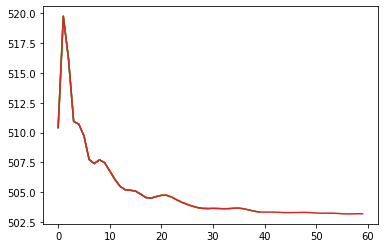

In [136]:
x1 = s_xvectors.clone().cuda() #.to(device)
steps = 40
for steps in [20, 30, 40, 60]:
    x2 = embeddings[other_set].clone().to(device)
    losses = []
    dloss = Dist_loss(ws[select_ids], metric='euclidean').to(x1.device)
    opt = torch.optim.Adam(dloss.parameters(), lr=.3, weight_decay=0)

    for i in range(steps):
        L_αβ = dloss(x1, x2)
        losses.append(float(L_αβ.item()))
        L_αβ.backward()
        opt.step()
        # print(dloss.w.data.squeeze()[:10])
        opt.zero_grad()
            # w = torch.clamp(dloss.w.data.cpu(), min=0, max=2, out=None) #dloss.w.data.squeeze().abs()

    plt.plot(losses)
    print('{} {:.4f} {} '.format(steps, np.min(losses), np.argmin(losses)))
    
# 0.1
# 20 503.4534 19 
# 30 503.4202 20 
# 40 503.2956 39 
# 60 503.2195 48 

# 0.2
# 20 504.0794 19 
# 30 503.4644 28 
# 40 503.2004 36 
# 60 503.0920 47

# 0.3
# 20 504.4903 18 
# 30 503.6195 29 
# 40 503.3297 39 
# 60 503.1680 56 

503.200439453125


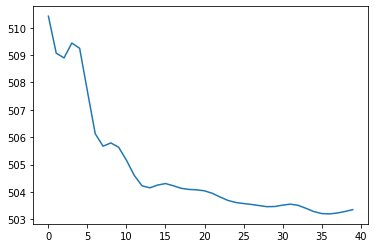

In [124]:
plt.plot(losses)
print(np.min(losses))

In [105]:
w = torch.nn.functional.softmax(dloss.w.data.cpu().squeeze(), dim=0)
# w =  torch.clamp(self.w, min=0, max=2, out=None)
w = w / w.mean()

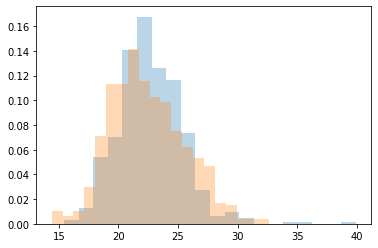

In [77]:
_ = plt.hist(x1.norm(dim=1).cpu(), bins=20, alpha=0.3, density=True)
_ = plt.hist(x1.norm(dim=1).cpu()*w, bins=20, alpha=0.3, density=True)

In [106]:
y = x1.norm(dim=1).cpu()
idx = torch.sort(y).indices
idx_w = torch.sort(w).indices

In [ ]:
w[idx_w]

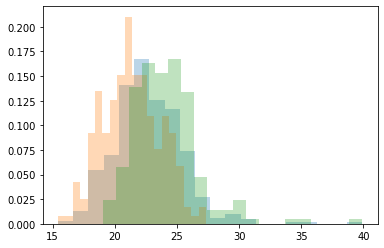

In [89]:
_ = plt.hist(y, bins=20, alpha=0.3, density=True)
_ = plt.hist(y[idx_w[-200:]], bins=20, alpha=0.3, density=True)
_ = plt.hist(y[idx_w[:200]], bins=20, alpha=0.3, density=True)


In [ ]:
from geomloss import SamplesLoss

In [90]:
loss_func = SamplesLoss("sinkhorn", p=2, blur=0.05, cost=lambda a, b: cost_func(a, b, p=2, metric='euclidean'))

In [91]:
op_1 = loss_func(x1[idx_w[-200:]], x2)
op_2 = loss_func(x1[idx_w[:200]], x2)
print(op_1.float(), op_2)

tensor(513.7578, device='cuda:1') tensor(627.0327, device='cuda:1')


In [109]:
for num in [100, 200, 300, 400]:
    op_1 = loss_func(x1[idx_w[-num:]], x2)
    op_2 = loss_func(x1[idx_w[:num]], x2)
    # print(op_1.float(), op_2)

    loss_rand = []
    for i in range(10):
        x1_samples = np.arange(len(x1))
        np.random.shuffle(x1_samples)
        rand_idx = torch.LongTensor(x1_samples[-num:]).to(device)
        loss_rand.append(loss_func(x1[rand_idx], x2).cpu().float())

    print("Num samples {}:   {:.3f}  {:.3f}  {:.3f}".format(num, float(op_1), float(op_2), np.mean(loss_rand)))

Num samples 100:   583.221  607.585  609.971
Num samples 200:   550.648  571.213  565.056
Num samples 300:   532.802  549.206  538.933
Num samples 400:   521.501  530.257  523.952


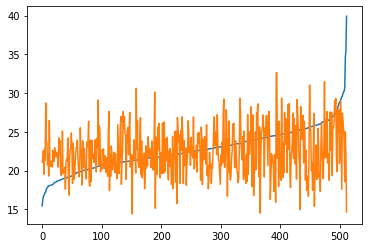

In [81]:
plt.plot(y[idx])
plt.plot((y*w)[idx])

In [ ]:
x1.norm(dim=1).cpu()*w

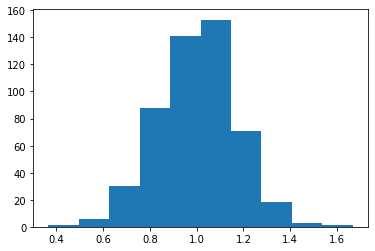

In [69]:
_ = plt.hist(w)

In [119]:
# dloss.w.grad
# ws[:100]
idx = torch.sort(ws.squeeze()).indices
ws[idx[-100:]]

tensor([[1.0218],
        [1.0218],
        [1.0218],
        [1.0219],
        [1.0219],
        [1.0219],
        [1.0219],
        [1.0219],
        [1.0220],
        [1.0220],
        [1.0220],
        [1.0220],
        [1.0221],
        [1.0221],
        [1.0221],
        [1.0221],
        [1.0221],
        [1.0221],
        [1.0221],
        [1.0221],
        [1.0222],
        [1.0222],
        [1.0222],
        [1.0222],
        [1.0222],
        [1.0223],
        [1.0223],
        [1.0223],
        [1.0223],
        [1.0223],
        [1.0223],
        [1.0223],
        [1.0223],
        [1.0224],
        [1.0224],
        [1.0224],
        [1.0225],
        [1.0225],
        [1.0226],
        [1.0226],
        [1.0226],
        [1.0227],
        [1.0227],
        [1.0228],
        [1.0228],
        [1.0228],
        [1.0228],
        [1.0228],
        [1.0229],
        [1.0229],
        [1.0230],
        [1.0231],
        [1.0232],
        [1.0232],
        [1.0232],
        [1

In [116]:
idx.shape

torch.Size([386301, 1])

In [550]:
torch.save({'weights': ws}, 'data/vox2/weight.adam.512.pth')

In [286]:
import pandas as pd

In [287]:
train_utts = pd.DataFrame(train_dir.base_utts, columns=['uid', 'start', 'end'])
train_utts['scores'] = ws.squeeze().numpy()

train_utts.to_csv(os.path.join('data/vox2', 'subtrain.{}.scores.csv'.format(0)),
                  index=None)

In [293]:
scores_utts = pd.read_csv(os.path.join('data/vox2', 'subtrain.{}.scores.csv'.format(0))).to_numpy()

In [295]:
scores_utts[:, -1].astype(np.float32)

array([1.0109581 , 1.0425051 , 0.9720516 , ..., 0.98818487, 1.007649  ,
       1.0005752 ], dtype=float32)

In [299]:
isinstance(scores_utts, np.ndarray)

True

In [298]:
type(np.array([0]))

numpy.ndarray

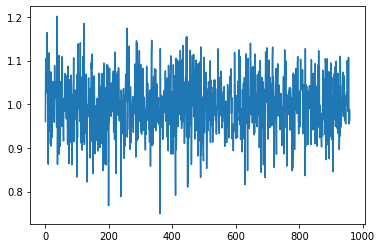

In [551]:
plt.plot(ws[:192*5])

In [276]:
 torch.clamp(dloss.w, min=0, max=None, out=None).squeeze()

tensor([1.0847, 0.7928, 0.9437, 0.9226, 1.0970, 0.9642, 0.8300, 0.7533, 1.0684,
        0.9703, 1.2075, 0.8556, 0.9872, 1.0142, 0.8874, 0.9423, 1.0489, 0.8062,
        0.9436, 0.9211, 0.7868, 0.8112, 1.0417, 0.9621, 1.1970, 0.6961, 0.7554,
        0.8663, 1.1496, 0.8346, 0.9528, 1.0622, 1.2156, 0.9771, 1.1184, 0.8449,
        1.0420, 1.2011, 1.0929, 0.9940, 0.9283, 1.2092, 0.9854, 0.9348, 1.0021,
        0.8265, 1.0707, 1.1061, 1.1406, 1.1476, 1.1865, 0.9351, 0.9794, 1.1467,
        0.9899, 1.0639, 0.8515, 0.9758, 0.8566, 0.9828, 0.9257, 0.9806, 1.1537,
        0.9151, 1.0171, 1.0892, 1.1026, 0.7150, 1.0516, 1.0144, 1.2819, 1.0385,
        1.1359, 1.0043, 0.9578, 0.9713, 1.2582, 1.0290, 0.9604, 1.1242, 0.9068,
        0.8332, 0.9394, 0.9187, 1.1651, 0.6764, 0.7592, 1.2796, 0.9830, 1.0989,
        0.8486, 0.9984, 0.8949, 0.9937, 1.0046, 1.1887, 0.9522, 1.0982, 0.7692,
        0.9274, 0.9178, 0.9645, 1.0143, 1.0372, 1.1319, 0.9459, 1.2759, 1.0260,
        0.9607, 1.1045, 1.0587, 1.0580, 

In [507]:
# from Process_Data.Datasets.SelectDataset import cost_func

# class Dist_loss(nn.Module):
#     def __init__(self, w, metric='cosine'):
#         super(Dist_loss, self).__init__()
#         w = w/w.mean()
#         self.w = nn.Parameter(w)
#         self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
#                                 cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
#                                 # SamplesLoss("sinkhorn", p=2, blur=0.1)
#     def forward(self, x1, x2):
#         w = self.w.abs()
#         w = w / w.mean()
        
#         return self.loss(w*x1, x2)
    
def cost_func(a, b, p=2, metric='cosine'):
    """ a, b in shape: (B, N, D) or (N, D)
    """ 
    assert type(a)==torch.Tensor and type(b)==torch.Tensor, 'inputs should be torch.Tensor'
    if metric=='euclidean' and p==1:
        return geomloss.utils.distances(a, b)
    elif metric=='euclidean' and p==2:
        return geomloss.utils.squared_distances(a, b)
    else:
        if a.dim() == 3:
            x_norm = a / (a.norm(dim=2)[:, :, None]+1e-12)
            y_norm = b / (b.norm(dim=2)[:, :, None]+1e-12)
            M = 1 - torch.bmm(x_norm, y_norm.transpose(-1, -2))
        elif a.dim() == 2:
            x_norm = a / (a.norm(dim=1)[:, None]+1e-12)
            y_norm = b / (b.norm(dim=1)[:, None]+1e-12)
            M = 1 - torch.mm(x_norm, y_norm.transpose(0, 1))
        # M = pow(M, p)
        return M
    
class Dist_loss(nn.Module):
    def __init__(self, w, lamda=0, portion=0.8, metric='cosine'):
        super(Dist_loss, self).__init__()
        w = w/w.mean()
        self.w = nn.Parameter(w)
        self.loss = SamplesLoss("sinkhorn", p=2, blur=0.05,
                                cost=lambda a, b: cost_func(a, b, p=2, metric=metric))
        self.lamda = lamda
        self.portion = portion
        # self.sig = nn.Sigmoid()
    
    def get_w(self):
        w = torch.clamp(self.w, min=0.0, max=2, out=None)
        w = w/w.mean()
        return w

    def forward(self, x1, x2):
        # w = 2 * self.sig(self.w)
        # w = torch.clamp(self.w, min=0.0, max=2, out=None)
        # w = w/w.mean()
        w = self.get_w()
        
        return self.loss(w*x1, x2) + self.lamda * ((w <= 1).sum()/w.numel() - self.portion).abs()

In [183]:
x1 = s_xvectors.clone().cuda() #.to(device)
dloss = Dist_loss(ws[select_ids], metric=metric).to(x1.device)

other_set = bigger_samples[np.random.choice(np.arange(len(bigger_samples)))]

x2 = embeddings[other_set].clone().to(device)
opt = torch.optim.SGD(dloss.parameters(), lr=0.2, weight_decay=0)

for i in range(10):
    L_αβ = dloss(x1, x2)
    L_αβ.backward()
    
    dloss.w.data = dloss.w.data - 0.2*dloss.w.grad
    
    opt.step()
    opt.zero_grad()

In [259]:
steps = 40

In [434]:
96 * np.arange(1, 6)

array([ 96, 192, 288, 384, 480])

In [543]:
np.random.seed(1234)

steps  = 40
batch_sizes = 2 ** np.arange(6, 11)

total_loss = []
weights = {i:[] for i in [10, 20, 30, 40]}
ws =  torch.ones(sample_num, 1) #+0.5

for b in batch_sizes:
    select_ids = (np.arange(b) + b*i) % sample_num

    s_xvectors = embeddings[select_ids]
    x1 = s_xvectors.clone().cuda() 
    
    bigger_batch_size = int(b*4)
    bigger_samples = np.arange(sample_num)
    np.random.seed(1234)
    np.random.shuffle(bigger_samples)
    bigger_samples = bigger_samples[:int(sample_num/bigger_batch_size) * bigger_batch_size].reshape(-1, bigger_batch_size)
    other_set = bigger_samples[np.random.choice(np.arange(len(bigger_samples)))]
    
    x2 = embeddings[other_set].clone().to(device)
        
    dloss = Dist_loss(ws[select_ids].clone(), lamda=0,).to(x1.device)
    opt = torch.optim.Adam(dloss.parameters(), lr=2, weight_decay=0)

    loss = []
    for i in range(steps):
        # L_αβ = OT_solver(w*x1, x2)
        L_αβ = dloss(x1, x2)
        L_αβ.backward()
        opt.step()
        # opt.zero_grad()

        loss.append(float(L_αβ.item()))
        
        if (i+1) % 10 == 0:
            weights[i+1].append(dloss.get_w().data.squeeze().cpu().numpy())
    
    total_loss.append(loss)

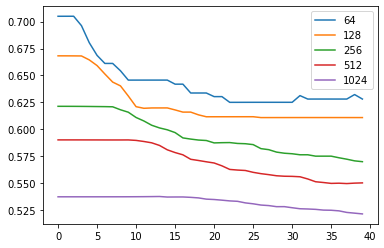

In [544]:
for t in total_loss:
    plt.plot(t)
    
plt.legend([str(b) for b in batch_sizes])

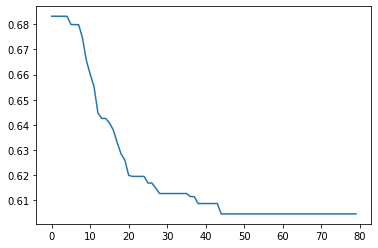

In [512]:
# for t in :
plt.plot(total_loss[0])
    
# plt.legend([str(b) for b in batch_sizes])

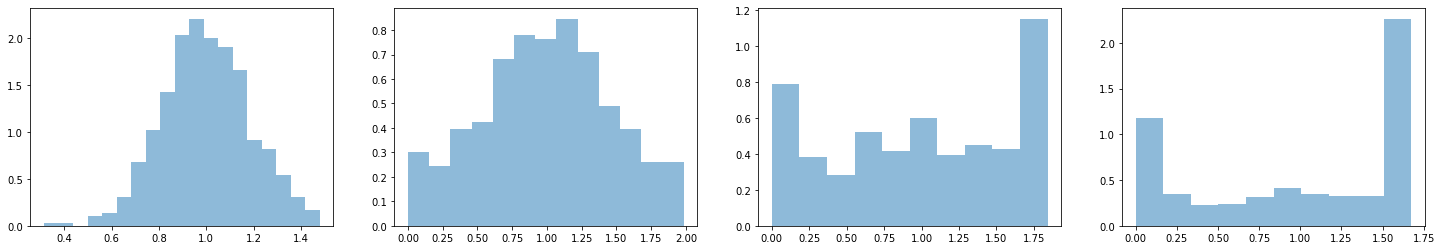

In [519]:
plt.figure(figsize=(25, 4))
for i, t in enumerate(weights):
    plt.subplot(1, len(weights),  i+1)
    plt.hist(weights[t][-1], bins='auto', density=True, alpha=0.5)
    
    # plt.legend([str(batch_sizes[i])])

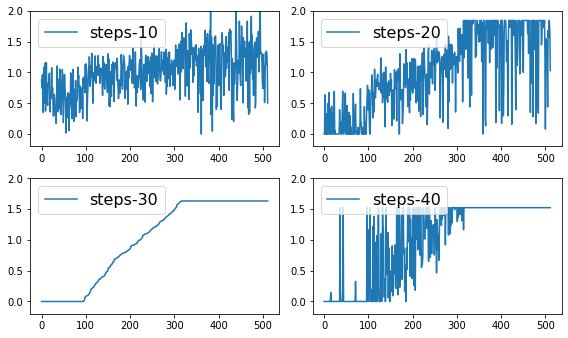

In [548]:
plt.figure(figsize=(8, 4.8))
j = -2
sort_idx = np.argsort(weights[30][j])

for i, t in enumerate([weights[i][j] for i in weights]):
    plt.subplot(2, len(weights)//2,  i+1)
    # plt.hist(t, bins='auto', density=True, alpha=0.5)
    plt.plot(t[sort_idx])
    plt.ylim([-0.2, 2])

    plt.legend(['steps-' + str((i+1) * 10)], fontsize=16, loc='upper left')
plt.tight_layout()

plt.savefig('score_convergence.png')

In [411]:
np.mean([4.605, 4.625, 4.867])

4.699000000000001

(array([ 11.,  23.,  58., 100., 160., 178., 126.,  68.,  38.,   6.]),
 array([0.02689774, 0.21658729, 0.40627682, 0.5959664 , 0.78565592,
        0.97534549, 1.16503501, 1.35472453, 1.54441416, 1.73410368,
        1.9237932 ]),
 <BarContainer object of 10 artists>)

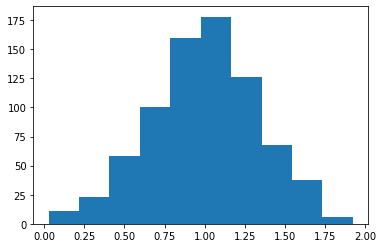

In [343]:
plt.hist(torch.clamp(dloss.w.data.squeeze(), min=0.0, max=2.0, out=None).cpu().numpy())

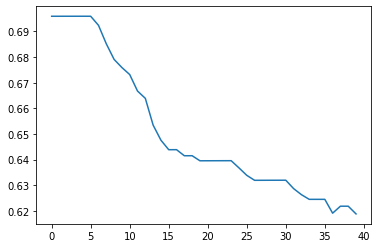

In [269]:
plt.plot(loss)

In [271]:
w = torch.clamp(dloss.w, min=0, max=2, out=None) #dloss.w.data.squeeze().abs()
w /= w.mean()

print(w.squeeze())

tensor([0.1019, 0.0000, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 0.0000,
        0.0000, 1.6039, 0.0000, 0.0000, 0.0000, 0.0000, 1.6039, 0.0000, 0.0000,
        1.6039, 1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039,
        0.0000, 0.0000, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 0.0000, 1.6039,
        1.6039, 0.0000, 1.6039, 1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039,
        1.6039, 1.6039, 1.6039, 1.6039, 0.0000, 1.6039, 0.1770, 1.6039, 1.6039,
        1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 1.3998,
        1.5241, 1.6039, 0.8081, 0.0000, 0.0000, 1.6039, 0.0000, 1.6039, 0.0323,
        0.0000, 1.6039, 1.6039, 0.0000, 0.0000, 1.6039, 1.6039, 1.6039, 0.0000,
        1.6039, 1.6039, 1.6039, 1.6039, 1.6039, 0.0000, 0.0000, 0.5347, 1.6039,
        1.6039, 1.6039, 1.6039, 1.6039, 0.0000, 1.6039], device='cuda:1',
       grad_fn=<SqueezeBackward0>)


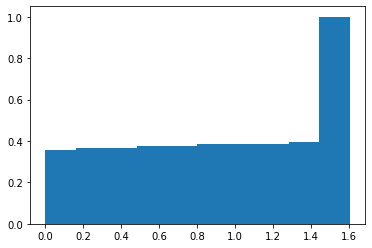

In [272]:
_ = plt.hist(w.squeeze().detach().cpu().numpy(), bins=10, density=True, cumulative=True)
plt.savefig('lamda=0.png')

In [83]:
x1.shape, x2.shape

(torch.Size([96, 192]), torch.Size([384, 192]))

In [ ]:
torch.save({'weights': ws}, 'data/vox2/weight.pth')

### Sample balance

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Random